In [1]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from decorators import timing_log


# Create a custom_scorer that is used for both inner and outer cv
def gini_scorer(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1
    return gini
custom_scorer = make_scorer(gini_scorer, greater_is_better=True, needs_proba=True)

class FeatureSelector:
    """This feature selector takes any estimator, scoring and CV methods 
    and feature selection configurations and return the best set selectioned through RFE. 
    """
    def __init__(self, estimator, min_features_to_select=2, step=1, scorer=None, cv=None):
        """
        Initialize the FeatureSelector.

        Args:
            estimator: The estimator to be used for feature selection, e.g., a classifier or regressor.
            n_features_to_select: The number of features to select. If None, half of the features will be selected.
            step: The number of features to remove at each iteration (default is 1).
            cv: Cross-validation generator (default is StratifiedKFold with 5 folds).
        """
        self.estimator = estimator
        self.min_features_to_select = min_features_to_select
        self.step = step
        self.scorer = scorer
        self.cv = cv
    
    @timing_log
    def select_features(self, X, y):
        """
        Select the best features using RFE (Recursive Feature Elimination) and cross-validation.

        Parameters:
            X: The feature matrix.
            y: The target values.

        Returns:
            selected_features: The selected feature indices.
        """
        self.rfecv = RFECV(estimator=self.estimator, 
                  min_features_to_select=self.min_features_to_select, 
                  step=self.step,
                  scoring=self.scorer,
                  cv=self.cv)
        selected_feature_indices = self.rfecv.fit(X, y).support_
        selected_features = X.iloc[:, selected_feature_indices].columns.tolist()
        cv_score = np.max(self.rfecv.cv_results_['mean_test_score'])

        return selected_features, cv_score
    
    def summary_plot(self):
        n_scores = len(self.rfecv.cv_results_["mean_test_score"])
        feature_numbers = range(self.min_features_to_select, n_scores + self.min_features_to_select)

        # Find the index of the maximum mean test score
        max_score_index = np.argmax(self.rfecv.cv_results_["mean_test_score"])
        max_score = self.rfecv.cv_results_["mean_test_score"][max_score_index]
        print(f'the max test score is {max_score:.3} achieved with {max_score_index+self.min_features_to_select} features')
        
        # Calculate the y-axis limits
        min_y = min(self.rfecv.cv_results_["mean_test_score"] - self.rfecv.cv_results_["std_test_score"])
        max_y = max(self.rfecv.cv_results_["mean_test_score"] + self.rfecv.cv_results_["std_test_score"])
        
        # Plot the mean test scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean test score")
        plt.errorbar(
            feature_numbers,
            self.rfecv.cv_results_["mean_test_score"],
            yerr=self.rfecv.cv_results_["std_test_score"],
            label="Mean Test Score",
        )

        # Highlight the bar with the highest score by covering the entire y-axis range
        plt.bar(
            feature_numbers[max_score_index],
            max_y - min_y,  # Bar height
            bottom=min_y,   # Set the bottom of the bar to the minimum y-axis value
            color='red',    
            alpha=0.3,      
            label="Max Test Score",
        )

        # Add a textbox at the bottom right with information about the maximum score and number of features
        text_str = f"Max Score: {max_score:.3f}\n# of Features: {feature_numbers[max_score_index]}"
        plt.text(0.98, 0.02, text_str, transform=plt.gca().transAxes,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8))

        # Set y-axis limits for better visibility
        plt.ylim(min_y, max_y)

        plt.title("Feature Selection\nScore by number of features")
        # plt.legend()
        plt.show()

# Usage
if __name__ == '__main__':
    # Create a sample dataset for demonstration
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name="target")
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    estimator=lgb.LGBMClassifier(verbose=-1)

    # Initialize the FeatureSelector with the desired configuration
    feature_selector = FeatureSelector(estimator=estimator, 
                                       min_features_to_select=5,
                                       scorer = custom_scorer,
                                       cv = cv)
    
    # Select the best features using RFE and cross-validation
    selected_features, cv_score = feature_selector.select_features(X, y)
    print("Selected features:", selected_features)
    print("Cross-validation scores:", cv_score)  


Function 'select_features' took 4.433979 seconds to run
Selected features: ['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'area error', 'compactness error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']
Cross-validation scores: 0.984172824059201


the max test score is 0.984 achieved with 24 features


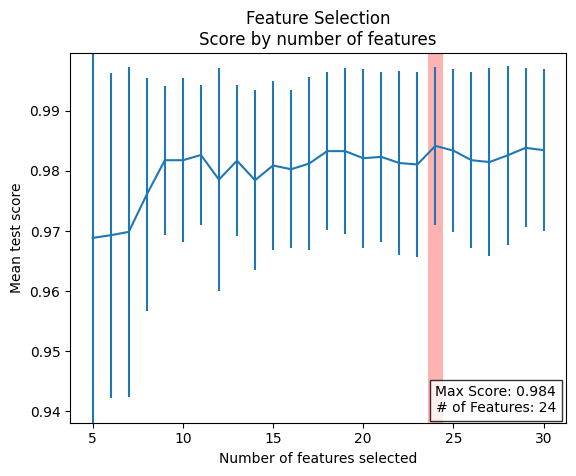

In [2]:
# plot the RFE process
feature_selector.summary_plot()

In [3]:
X_selected = X[selected_features]
X_selected.head()

,mean radius,mean texture,mean perimeter,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,...,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry
0,17.99,10.38,122.80,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,...,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601
1,20.57,17.77,132.90,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,...,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750
2,19.69,21.25,130.00,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,...,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613
3,11.42,20.38,77.58,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,...,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638
4,20.29,14.34,135.10,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,...,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364


### Feature Selector in the ML Pipeline

This feature selector then can be used in an ML Pipeline. For example, we can test its robustness under [nested_cross_validation](https://github.com/MenaWANG/ML_toy_examples/blob/main/tune%20models/nested_CV.ipynb)

In [4]:
from mlops_class import MLUtils

In [5]:
def nested_cv_feature_selection(X, y, estimator, feature_selector, scorer, cv_outer):
    """
    Perform nested cross-validation for feature selection.
    """
    outer_loop_log = {}
    test_scores = []
    selected_features_all_folds = []

    for i, (train_idx, test_idx) in enumerate(cv_outer.split(X,y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Perform feature selection using the inner cross-validation
        selected_features, inner_score = feature_selector.select_features(X_train, y_train)
        # Train the estimator on the selected features
        estimator.fit(X_train[selected_features], y_train)
        # Evaluate the estimator on the test set
        score = scorer(estimator, X_test[selected_features], y_test)
        
        outer_loop_log[f'fold_{i}'] = {}
        outer_loop_log[f'fold_{i}']['test_score'] = score
        outer_loop_log[f'fold_{i}']['inner_cv_score'] = inner_score
        outer_loop_log[f'fold_{i}']['best_features'] = selected_features
        test_scores.append(score)
        selected_features_all_folds.append(selected_features)

    best_feature_set = MLUtils.get_best_fold(outer_loop_log, 'test_score', 'best_features')

    return best_feature_set

# Example usage
if __name__ == '__main__':
    # Create a sample dataset for demonstration
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns = data.feature_names)
    y = data.target
    
    # Define outer and inner cross-validation strategies
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # Initialize the FeatureSelector with an estimator, scoring and cv option
    feature_selector = FeatureSelector(estimator=lgb.LGBMClassifier(verbose=-1), 
                                       min_features_to_select=2,
                                       step = 1,
                                       scorer = custom_scorer,
                                       cv = cv_inner)
    
    # Perform nested cross-validation with above configuration
    best_features = nested_cv_feature_selection(X, y, estimator, feature_selector, 
                                                               scorer = custom_scorer,
                                                               cv_outer = cv_outer)


    # print("Selected features for fold 0:", X.loc[:,selected_features[0]].columns)


The best score is 0.999, and the std is 0.0111


In [6]:
print(best_features)

['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'area error', 'compactness error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


## Reflections and Next Step

What I really like about the above efforts

1. How cv, scorer, estimator are customized outside and then passed into feature_selector and nested_cv. 
2. Because of 1, the `feature_selector` is configured outside of nested_cv, and within nested_cv it only takes X and y as input
3. Because of 2, the `nested_cv_feature_selection` can be changed to be a more general purpose `nested_cv_optimizer`, it could accept any optimizer, such as `feature_selector`, and return the cv best_set, be it best feature_set or best hyperparams_set.
4. Afterwards, it is good to build a `HyperparamsTuner` which has similar interface with `feature_selector`. Then we can have `nested_cv_optimizer` calling both optimizer to get the best configuration.  

Let's make 3 and 4 the task for the next iteration (pls see `0.mlops_class build plan`). Also another nice functionality is to the number of times a feature is selected across all runs, maybe makes it a functionality of the feature_selector class. 